In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

# Load the user csv file with encoding set to 'ISO-8859-1'
user = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [2]:
# Load the engagement csv file with encoding set to 'ISO-8859-1'
login = pd.read_csv('takehome_user_engagement.csv', encoding='ISO-8859-1')
login.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [4]:
login['time_stamp'] = pd.to_datetime(login['time_stamp'])

In [5]:
# Create a column of date only without time
login['date_stamp'] = login['time_stamp'].dt.date

In [6]:
# Find out how many users had usage summary data
login['user_id'].nunique()

8823

In [7]:
# Eliminate multiple logins on the same day
for i in login['user_id'].unique():
    login[login['user_id']==i] = login[login['user_id']==i].drop_duplicates(subset=['date_stamp'])
# Examine if there is any user with multiple logins on the same day
login.isna().any()

time_stamp    False
user_id       False
visited       False
date_stamp    False
dtype: bool

**This dataset has been somehow cleaned before since there is no user with multiple logins on the same day.**

In [8]:
login['date_stamp'] = pd.to_datetime(login['date_stamp'])

In [9]:
login_day = login.sort_values(['user_id', 'date_stamp']).drop('time_stamp', axis=1).set_index('date_stamp')
login_day

,user_id,visited
date_stamp,,
2014-04-22,1,1
2013-11-15,2,1
2013-11-29,2,1
2013-12-09,2,1
2013-12-25,2,1
...,...,...
2013-09-06,11996,1
2013-01-15,11997,1
2014-04-27,11998,1


In [10]:
grouped = login_day.groupby('user_id')

In [11]:
# Identify users who logged into the product on three separate days in at least one seven-­day period
users_with_multiple_logins = []
for user_id, user_data in grouped:
    # Resample to get a continuous time series, filling in missing dates with 0 login counts
    user_data_resampled = user_data.resample('D').sum()
    # Check for any continuous 5-day periods with at least two logins
    if (user_data_resampled['visited'].rolling(window=7, min_periods=1).sum() >= 3).any():
        users_with_multiple_logins.append(user_id)

In [12]:
# Find out how many users adopted the product
len(users_with_multiple_logins)

1602

**There were 1602 users who logged into the product on three separate days in at least one seven-day period.**

In [13]:
# Create a new 'adopted' column in the user dataframe
for i in user.object_id:
    if i in users_with_multiple_logins:
        user.loc[i-1, 'adopted'] = 1
    else:
        user.loc[i-1, 'adopted'] = 0
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


**The `'adopted'` column will be the target variable.**

In [14]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted                     12000 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 1.0+ MB


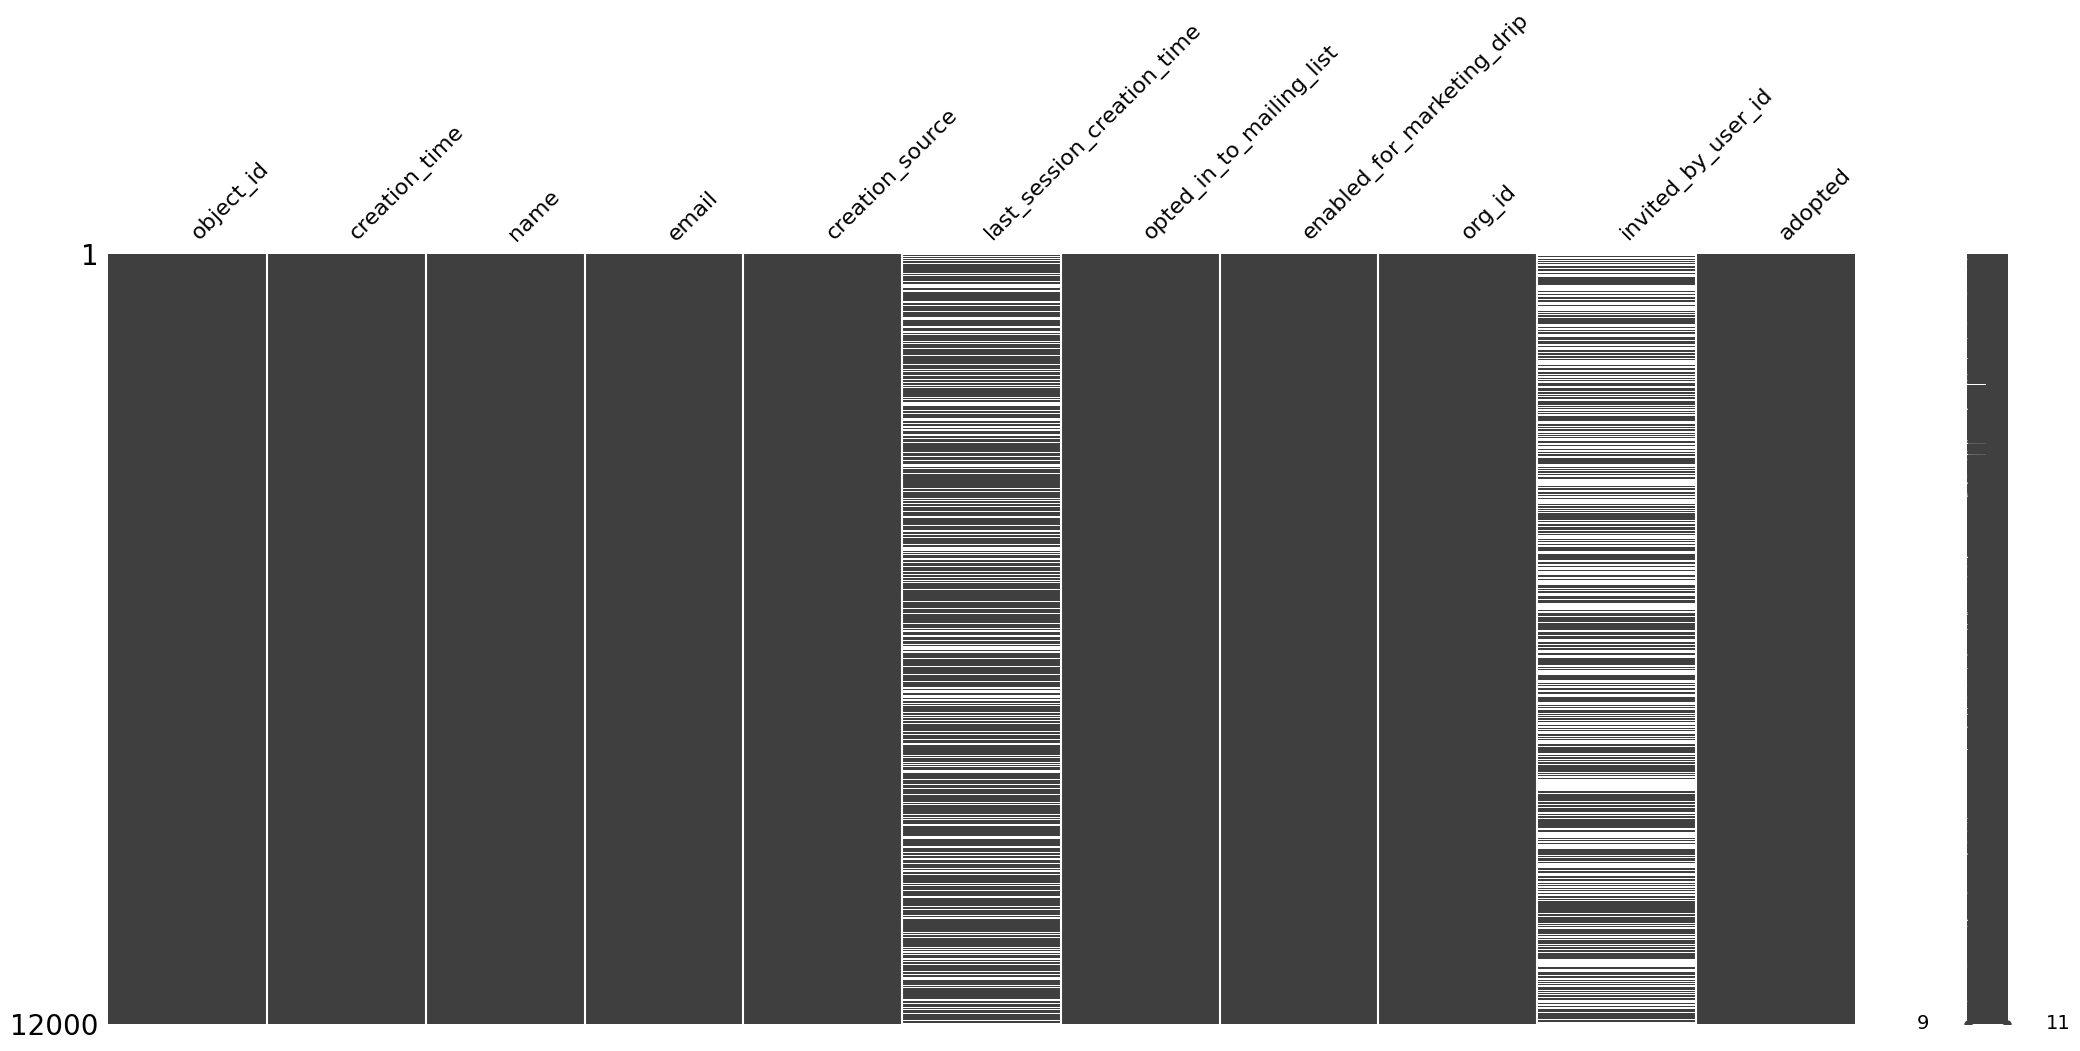

In [15]:
msno.matrix(user)
plt.show()

**There are only two features with missing values.**

In [16]:
user.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000,12000.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145,0.133500
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968,0.340128
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000,0.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000,0.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000,0.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000,0.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,1.000000


In [17]:
# Find duplicates in this dataframe
duplicates = user.duplicated(subset = ['name','email'], keep = False)
duplicate_user = user[duplicates]
duplicate_user.sort_values(['name'])

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
9040,9041,2013-01-03 00:53:47,Bach Amanda,AmandaABach@gmail.com,ORG_INVITE,NaN,0,0,377,6208.0,0.0
5280,5281,2012-09-29 11:54:08,Bach Amanda,AmandaABach@gmail.com,SIGNUP_GOOGLE_AUTH,1.401883e+09,0,0,146,NaN,1.0
4226,4227,2013-12-20 23:08:20,Brandt Thomas,ThomasBrandt@gmail.com,PERSONAL_PROJECTS,NaN,0,0,402,NaN,0.0
7628,7629,2012-11-18 11:37:48,Brandt Thomas,ThomasBrandt@gmail.com,PERSONAL_PROJECTS,NaN,0,0,24,NaN,0.0
8424,8425,2012-10-11 18:53:41,Duerr Leonie,LeonieDuerr@gmail.com,ORG_INVITE,1.350414e+09,0,0,2,1359.0,0.0
11905,11906,2014-04-14 21:24:59,Duerr Leonie,LeonieDuerr@gmail.com,ORG_INVITE,1.401917e+09,0,0,200,190.0,0.0
6705,6706,2012-06-27 06:19:12,Gerste Ulrike,UlrikeGerste@gmail.com,SIGNUP_GOOGLE_AUTH,1.340778e+09,0,1,333,NaN,0.0
6590,6591,2013-01-21 01:12:29,Gerste Ulrike,UlrikeGerste@gmail.com,SIGNUP_GOOGLE_AUTH,1.358731e+09,0,0,180,NaN,0.0
10299,10300,2013-10-12 20:05:03,Holm Nicolai,NicolaiSHolm@yahoo.com,ORG_INVITE,1.382040e+09,0,0,64,153.0,0.0
3582,3583,2012-12-10 15:41:20,Holm Nicolai,NicolaiSHolm@yahoo.com,GUEST_INVITE,1.355154e+09,1,0,243,4225.0,0.0


**We found multiple duplicate users with the same name and email address. However, they all belonged to different organizations thus we will keep these duplicates for now.**

In [18]:
# Convert the 'creation_time' column to Unix timestamps
# Convert nanoseconds to seconds
user['creation_time'] = pd.to_datetime(user['creation_time'])

user['creation_time_timestamp'] = user['creation_time'].astype(int) // 10**9
user.insert(2, 'creation_time_timestamp', user.pop('creation_time_timestamp'))
user.head()

,object_id,creation_time,creation_time_timestamp,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,1398138810,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,1384487104,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,1363734892,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,1369123768,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,1358417660,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


In [19]:
# Creat a 'retention_time' column to show how long the users have been using the product for
user['retention_time'] = user['last_session_creation_time'] - user['creation_time_timestamp']
user.insert(2, 'retention_time', user.pop('retention_time'))
user.head()

,object_id,creation_time,retention_time,creation_time_timestamp,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,0.0,1398138810,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,11750400.0,1384487104,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,0.0,1363734892,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,86400.0,1369123768,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,432000.0,1358417660,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


In [20]:
# Use frequency encoding to create based on their frequency of occurrence in the org_id and invited_by_user_id columns.
# This approach can capture the relative importance of each org and user ID based on their frequency.
org_id_counts = user.org_id.value_counts()
user['org_id_freq'] = user['org_id'].map(org_id_counts)
user.insert(len(user.columns)-3, 'org_id_freq', user.pop('org_id_freq'))

user_id_counts = user.invited_by_user_id.value_counts()
user['user_id_freq'] = user['invited_by_user_id'].map(user_id_counts)
user.insert(len(user.columns)-2, 'user_id_freq', user.pop('user_id_freq'))

user.head()

,object_id,creation_time,retention_time,creation_time_timestamp,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,org_id_freq,invited_by_user_id,user_id_freq,adopted
0,1,2014-04-22 03:53:30,0.0,1398138810,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,75,10803.0,1.0,0.0
1,2,2013-11-15 03:45:04,11750400.0,1384487104,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,233,316.0,3.0,1.0
2,3,2013-03-19 23:14:52,0.0,1363734892,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,32,1525.0,11.0,0.0
3,4,2013-05-21 08:09:28,86400.0,1369123768,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,233,5151.0,7.0,0.0
4,5,2013-01-17 10:14:20,432000.0,1358417660,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,16,5240.0,5.0,0.0


/var/folders/4s/dkhgvddx5kb346fv_thq5bqh0000gn/T/ipykernel_98476/1757498962.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  user.corr()
/var/folders/4s/dkhgvddx5kb346fv_thq5bqh0000gn/T/ipykernel_98476/1757498962.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  _ = sns.heatmap(user.corr())


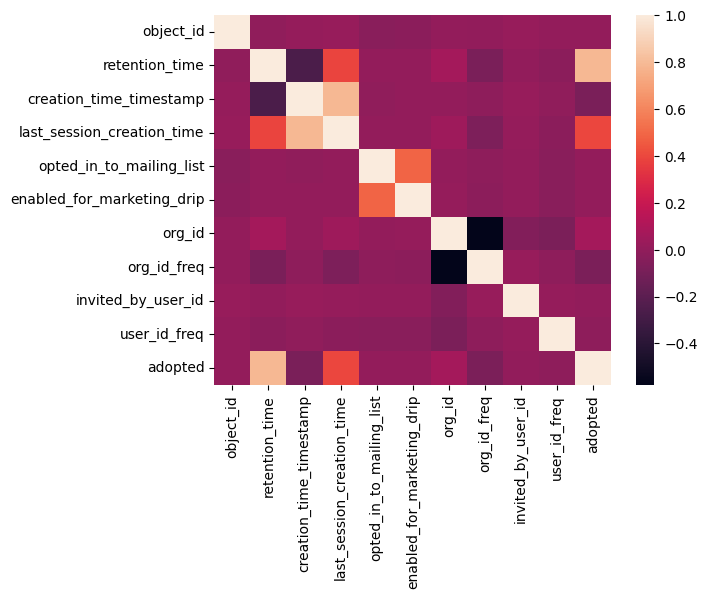

In [21]:
# Call the .corr() method on the dataset 
user.corr()

# Make a heatmap of the data 
_ = sns.heatmap(user.corr())
plt.show()

**There was a strong correlation between our target feature and `'retention_time'`. In addition, `'last_session_creation_time'` was also moderately correlated with the target variable.**

In [22]:
# Extract year, month, and day components
user['creation_year'] = user['creation_time'].dt.year
user['creation_month'] = user['creation_time'].dt.month
user['creation_day'] = user['creation_time'].dt.day

# Bin the month and day values into meaningful intervals
month_bins = [0, 3, 6, 9, 12] 
month_labels = ['Q1', 'Q2', 'Q3', 'Q4']

day_bins = [0, 7, 14, 21, 28, 31]
day_labels = ['Week1', 'Week2', 'Week3', 'Week4', 'Week5']

user['creation_month_bin'] = pd.cut(user['creation_month'], bins=month_bins, labels=month_labels)
user['creation_day_bin'] = pd.cut(user['creation_day'], bins=day_bins, labels=day_labels)

user.head()

,object_id,creation_time,retention_time,creation_time_timestamp,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,org_id_freq,invited_by_user_id,user_id_freq,adopted,creation_year,creation_month,creation_day,creation_month_bin,creation_day_bin
0,1,2014-04-22 03:53:30,0.0,1398138810,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,75,10803.0,1.0,0.0,2014,4,22,Q2,Week4
1,2,2013-11-15 03:45:04,11750400.0,1384487104,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,233,316.0,3.0,1.0,2013,11,15,Q4,Week3
2,3,2013-03-19 23:14:52,0.0,1363734892,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,32,1525.0,11.0,0.0,2013,3,19,Q1,Week3
3,4,2013-05-21 08:09:28,86400.0,1369123768,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,233,5151.0,7.0,0.0,2013,5,21,Q2,Week3
4,5,2013-01-17 10:14:20,432000.0,1358417660,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,16,5240.0,5.0,0.0,2013,1,17,Q1,Week3


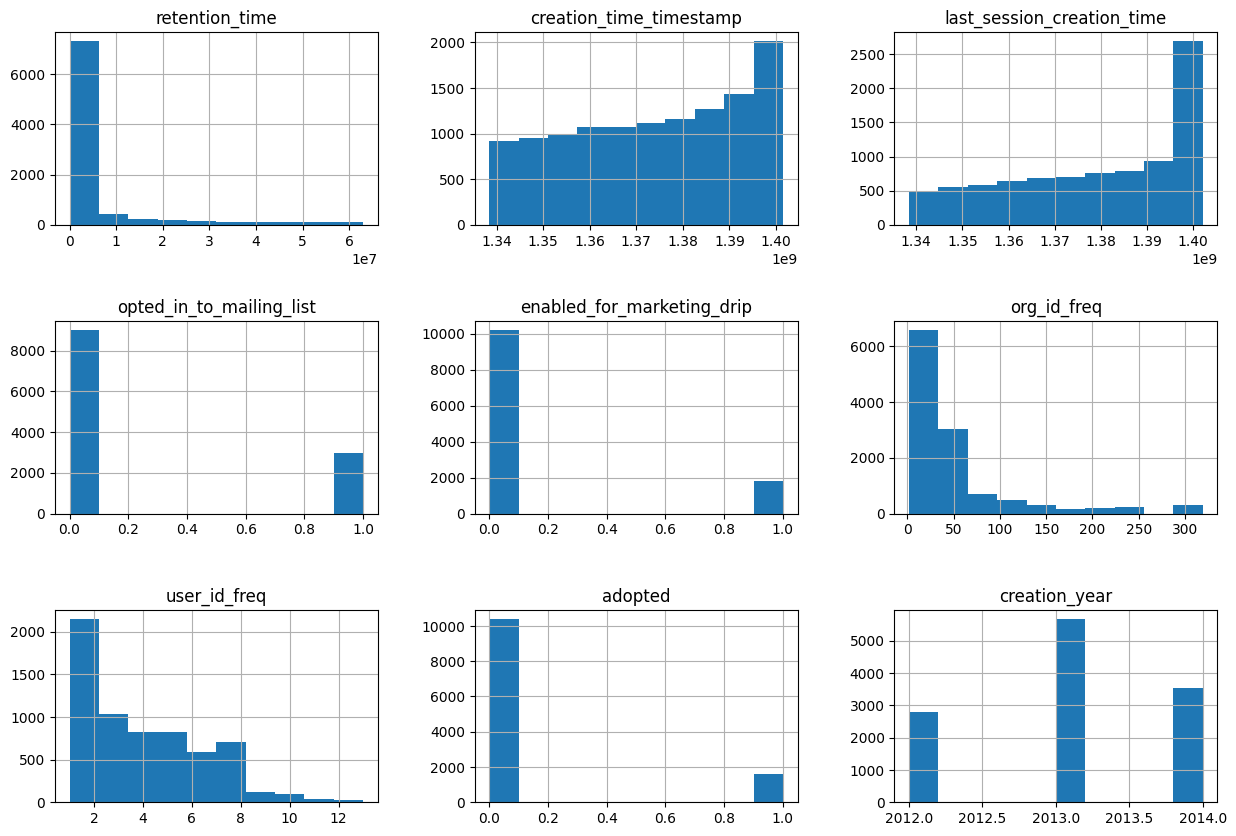

In [23]:
# Drop unnecessary columns
user_df = user.drop(['object_id','creation_time', 'creation_month', 'creation_day', 'name', 'email', 'org_id', 'invited_by_user_id'], axis=1)

# Look into distributions of feature values
user_df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

In [24]:
user_df.head()

,retention_time,creation_time_timestamp,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id_freq,user_id_freq,adopted,creation_year,creation_month_bin,creation_day_bin
0,0.0,1398138810,GUEST_INVITE,1.398139e+09,1,0,75,1.0,0.0,2014,Q2,Week4
1,11750400.0,1384487104,ORG_INVITE,1.396238e+09,0,0,233,3.0,1.0,2013,Q4,Week3
2,0.0,1363734892,ORG_INVITE,1.363735e+09,0,0,32,11.0,0.0,2013,Q1,Week3
3,86400.0,1369123768,GUEST_INVITE,1.369210e+09,0,0,233,7.0,0.0,2013,Q2,Week3
4,432000.0,1358417660,GUEST_INVITE,1.358850e+09,0,0,16,5.0,0.0,2013,Q1,Week3


In [25]:
# One hot encode the 'creation_source' 'creation_year' 'creation_month_bin' and 'creation_day_bin' columns
one_hot_encoded = pd.get_dummies(user_df, columns=['creation_source', 'creation_year', 'creation_month_bin', 'creation_day_bin'], prefix='OH')
print(one_hot_encoded.columns)

Index(['retention_time', 'creation_time_timestamp',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id_freq', 'user_id_freq', 'adopted',
       'OH_GUEST_INVITE', 'OH_ORG_INVITE', 'OH_PERSONAL_PROJECTS', 'OH_SIGNUP',
       'OH_SIGNUP_GOOGLE_AUTH', 'OH_2012', 'OH_2013', 'OH_2014', 'OH_Q1',
       'OH_Q2', 'OH_Q3', 'OH_Q4', 'OH_Week1', 'OH_Week2', 'OH_Week3',
       'OH_Week4', 'OH_Week5'],
      dtype='object')


In [26]:
# Reorganize numerical and categorical variables
one_hot_encoded.insert(7, 'opted_in_to_mailing_list', one_hot_encoded.pop('opted_in_to_mailing_list'))
one_hot_encoded.insert(7, 'enabled_for_marketing_drip', one_hot_encoded.pop('enabled_for_marketing_drip'))
one_hot_encoded.head()

,retention_time,creation_time_timestamp,last_session_creation_time,org_id_freq,user_id_freq,adopted,opted_in_to_mailing_list,enabled_for_marketing_drip,OH_GUEST_INVITE,OH_ORG_INVITE,...,OH_2014,OH_Q1,OH_Q2,OH_Q3,OH_Q4,OH_Week1,OH_Week2,OH_Week3,OH_Week4,OH_Week5
0,0.0,1398138810,1.398139e+09,75,1.0,0.0,1,0,1,0,...,1,0,1,0,0,0,0,0,1,0
1,11750400.0,1384487104,1.396238e+09,233,3.0,1.0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
2,0.0,1363734892,1.363735e+09,32,11.0,0.0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
3,86400.0,1369123768,1.369210e+09,233,7.0,0.0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
4,432000.0,1358417660,1.358850e+09,16,5.0,0.0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0


**Before we do any preprocessing to our data, we have to first split our data into training and test sets. To avoid data leakage, we will only train the pipeline of preprocessing on the train set, and keep the pipeline to apply it to the test set.**

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Subsetting our data into our dependent and independent variables.
y = one_hot_encoded[['adopted']]
X = one_hot_encoded.drop('adopted', axis=1)

# Split the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22, stratify=y)
X_train.head()

,retention_time,creation_time_timestamp,last_session_creation_time,org_id_freq,user_id_freq,opted_in_to_mailing_list,enabled_for_marketing_drip,OH_GUEST_INVITE,OH_ORG_INVITE,OH_PERSONAL_PROJECTS,...,OH_2014,OH_Q1,OH_Q2,OH_Q3,OH_Q4,OH_Week1,OH_Week2,OH_Week3,OH_Week4,OH_Week5
6668,NaN,1371285523,NaN,23,1.0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
6968,1555200.0,1375824134,1.377379e+09,19,8.0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
1353,0.0,1367697537,1.367698e+09,19,NaN,1,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
1541,NaN,1360144645,NaN,29,NaN,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
688,0.0,1378251378,1.378251e+09,17,4.0,1,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0


In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9600 entries, 6668 to 11189
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   retention_time              7071 non-null   float64
 1   creation_time_timestamp     9600 non-null   int64  
 2   last_session_creation_time  7071 non-null   float64
 3   org_id_freq                 9600 non-null   int64  
 4   user_id_freq                5161 non-null   float64
 5   opted_in_to_mailing_list    9600 non-null   int64  
 6   enabled_for_marketing_drip  9600 non-null   int64  
 7   OH_GUEST_INVITE             9600 non-null   uint8  
 8   OH_ORG_INVITE               9600 non-null   uint8  
 9   OH_PERSONAL_PROJECTS        9600 non-null   uint8  
 10  OH_SIGNUP                   9600 non-null   uint8  
 11  OH_SIGNUP_GOOGLE_AUTH       9600 non-null   uint8  
 12  OH_2012                     9600 non-null   uint8  
 13  OH_2013                     9

In [29]:
# Instantiate an imputer
imputer = SimpleImputer(strategy='median')

# Instantiate a scaler
scaler = StandardScaler()

# Build steps for the preprocessing pipeline
steps = [("imputer", imputer),
        ('standardization', scaler)]

# Set up pipeline
pipeline = Pipeline(steps)

# Apply fit_transform to numerical variables of X_train
X_train_num = pipeline.fit_transform(X_train.loc[:,'retention_time':'user_id_freq'])

# Apply transform to numerical variables of X_test
X_test_num = pipeline.transform(X_test.loc[:,'retention_time':'user_id_freq'])

In [30]:
# Recreate a DataFrame of the numeric features for X_train
X_train_num = pd.DataFrame(X_train_num, index=X_train.index, columns=X_train.columns[:5])

# Recreate a DataFrame of all the features (numerical + categorical) for X_train
X_train = pd.concat([X_train_num, X_train.loc[:,'OH_GUEST_INVITE':'OH_Week5']], axis=1)
X_train.describe()

,retention_time,creation_time_timestamp,last_session_creation_time,org_id_freq,user_id_freq,OH_GUEST_INVITE,OH_ORG_INVITE,OH_PERSONAL_PROJECTS,OH_SIGNUP,OH_SIGNUP_GOOGLE_AUTH,...,OH_2014,OH_Q1,OH_Q2,OH_Q3,OH_Q4,OH_Week1,OH_Week2,OH_Week3,OH_Week4,OH_Week5
count,9.600000e+03,9.600000e+03,9.600000e+03,9.600000e+03,9.600000e+03,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,...,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000
mean,1.850372e-17,4.933461e-15,-3.830269e-16,-6.383782e-17,4.588922e-17,0.179583,0.358021,0.174687,0.174063,0.113646,...,0.293021,0.258750,0.288750,0.219167,0.233333,0.219479,0.231875,0.230000,0.238542,0.080104
std,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,0.383860,0.479443,0.379719,0.379183,0.317397,...,0.455172,0.437971,0.453205,0.413703,0.422975,0.413915,0.422052,0.420854,0.426214,0.271469
min,-3.477922e-01,-1.905590e+00,-2.489658e+00,-8.275828e-01,-1.680628e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-3.477922e-01,-8.405081e-01,-5.656462e-01,-5.304432e-01,-5.510315e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-3.398686e-01,9.378346e-02,1.607719e-01,-4.053317e-01,1.376696e-02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-3.240216e-01,9.051792e-01,7.985839e-01,1.280437e-03,1.376696e-02,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.412620e+00,1.470029e+00,1.294587e+00,4.129958e+00,5.096953e+00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
# Likewise, recreate a DataFrame of all the features (numerical + categorical) for X_test
X_test_num = pd.DataFrame(X_test_num, index=X_test.index, columns=X_test.columns[:5])
X_test = pd.concat([X_test_num, X_test.loc[:,'OH_GUEST_INVITE':'OH_Week5']], axis=1)
X_test.describe()

,retention_time,creation_time_timestamp,last_session_creation_time,org_id_freq,user_id_freq,OH_GUEST_INVITE,OH_ORG_INVITE,OH_PERSONAL_PROJECTS,OH_SIGNUP,OH_SIGNUP_GOOGLE_AUTH,...,OH_2014,OH_Q1,OH_Q2,OH_Q3,OH_Q4,OH_Week1,OH_Week2,OH_Week3,OH_Week4,OH_Week5
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.00000,2400.000000,2400.00000,2400.000000,2400.000000,2400.000000,2400.000000
mean,-0.003396,-0.012716,-0.011339,0.014886,-0.014238,0.182917,0.340417,0.180833,0.173333,0.122500,...,0.297500,0.273333,0.288750,0.20875,0.229167,0.22625,0.207917,0.235833,0.242083,0.087917
std,1.002200,1.009098,1.005097,1.006229,0.949293,0.386679,0.473948,0.384960,0.378614,0.327931,...,0.457254,0.445763,0.453276,0.40650,0.420384,0.41849,0.405901,0.424607,0.428434,0.283233
min,-0.347792,-1.902934,-2.483195,-0.733749,-1.680628,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,-0.339869,-0.850555,-0.626129,-0.546082,-0.551032,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,-0.339869,0.079687,0.160772,-0.405332,0.013767,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,-0.322041,0.895102,0.796809,0.016919,0.013767,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,5.428467,1.469564,1.286147,4.129958,4.532155,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


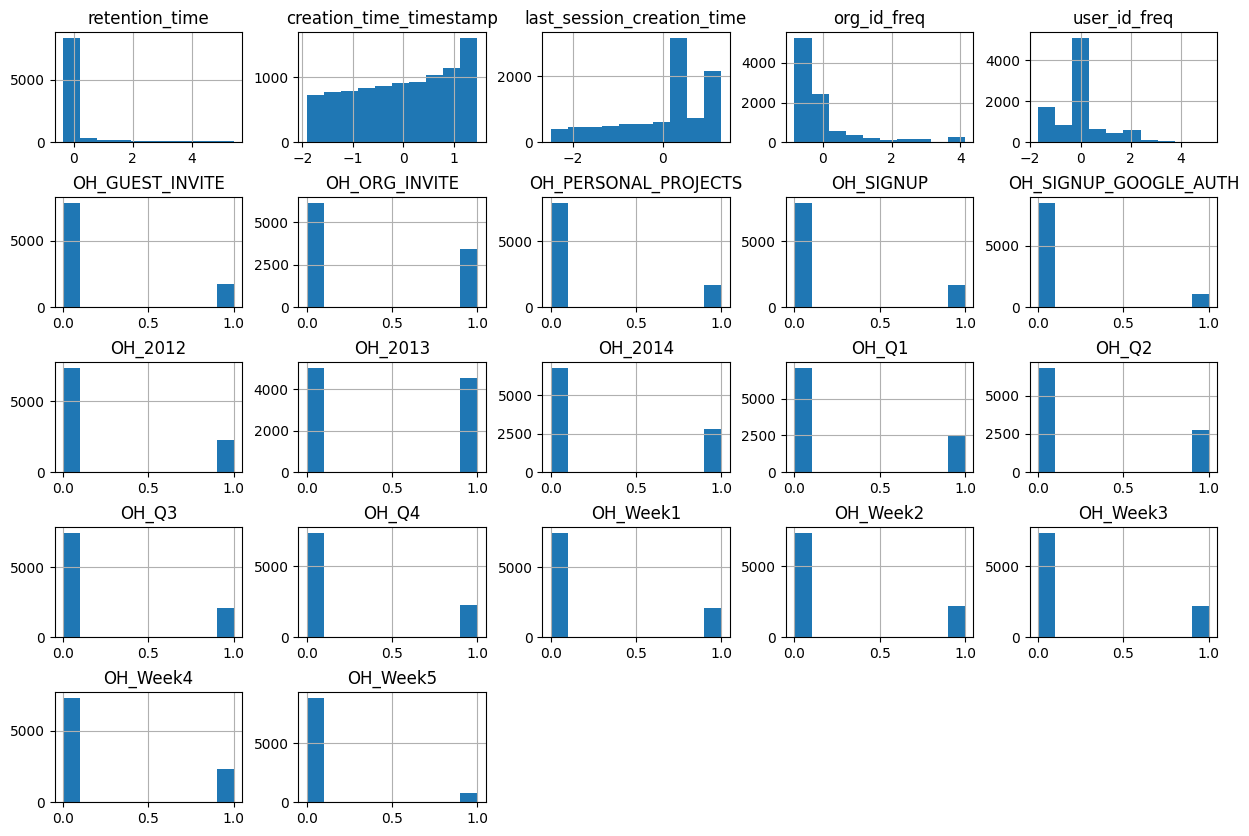

In [32]:
# Look into distributions of feature values after preprocessing
X_train.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

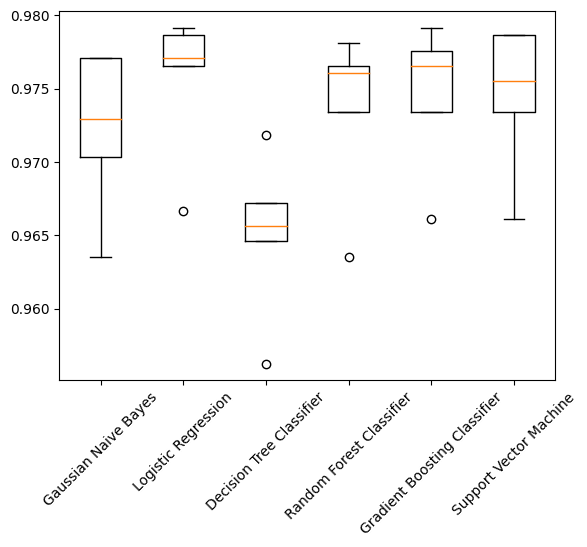

In [33]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Create models dictionary
models = {
    "Gaussian Naive Bayes": GaussianNB(), 
    "Logistic Regression": LogisticRegression(random_state=22),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=22),
    "Random Forest Classifier": RandomForestClassifier(random_state=22),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=22),
    "Support Vector Machine": SVC(random_state=22)
}
results = []

# Loop through the models' values
for model in models.values():
  
  # Instantiate a KFold object to perform 5 splits, setting shuffle to True and random_state to 22.
  kf = KFold(n_splits=5, random_state=22, shuffle=True)
  
  # Perform cross-validation
  cv_results = cross_val_score(model, X_train, y_train.values.ravel(), cv=kf)
  results.append(cv_results)
plt.boxplot(results, labels=models.keys())
plt.xticks(rotation=45)
plt.show()

**This is a binary classificaiton problem. We first did a quick comparison for multiple classification models with default settings and investigated which one performed the best out of the box. Logistic Regression is clearly a winner with the highest accuracy score in this case.**

In [34]:
import time

# Logistic Regression
# Create the parameter space
params = {"penalty": ["l2"],
         "tol": np.linspace(0.0001, 1.0, 50),
         "C": [0.001, 0.01, 0.1, 1.0, 10, 100],
         "max_iter": [1000]}

# Instantiate a KFold object to perform 5 splits, setting shuffle to True and random_state to 22.
kf = KFold(n_splits=5, random_state=22, shuffle=True)

# Instantiate the GridSearchCV object
logreg_cv = RandomizedSearchCV(LogisticRegression(random_state=22), params, cv=kf)

start_time = time.time()

# Fit the data to the model
logreg_cv.fit(X_train, y_train.values.ravel())

elapsed_time = time.time() - start_time
print("RandomizedSearchCV Run Time: %.3f" % (elapsed_time))

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Best Accuracy Score: %.3f" % (logreg_cv.best_score_))

RandomizedSearchCV Run Time: 12.951
Tuned Logistic Regression Parameters: {'tol': 0.3878163265306122, 'penalty': 'l2', 'max_iter': 1000, 'C': 1.0}
Tuned Logistic Regression Best Accuracy Score: 0.976


In [38]:
# Logistic Regression

# Instantiate a KFold object to perform 5 splits, setting shuffle to True and random_state to 22.
kf = KFold(n_splits=5, random_state=22, shuffle=True)

# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 1.0, 
                            max_iter = 1000, 
                            penalty = 'l2', 
                            tol = 0.3878163265306122, 
                            random_state=22)

# Fit the data to the model
logreg.fit(X_train, y_train.values.ravel())

# Predict using the model
y_pred_logreg = logreg.predict(X_test)

# Predict probabilities of each user adopting the program (which is in the 2nd column of the output of .predict_proba)
y_pred_prob_logreg = logreg.predict_proba(X_test)
adopted_prob_logreg = y_pred_prob_logreg[:,1]


Gradient Boosting: Accuracy=0.970
Gradient Boosting: f1-score=0.970
Gradient Boosting: log-loss=1.066
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      2080
         1.0       0.92      0.85      0.88       320

    accuracy                           0.97      2400
   macro avg       0.95      0.92      0.93      2400
weighted avg       0.97      0.97      0.97      2400



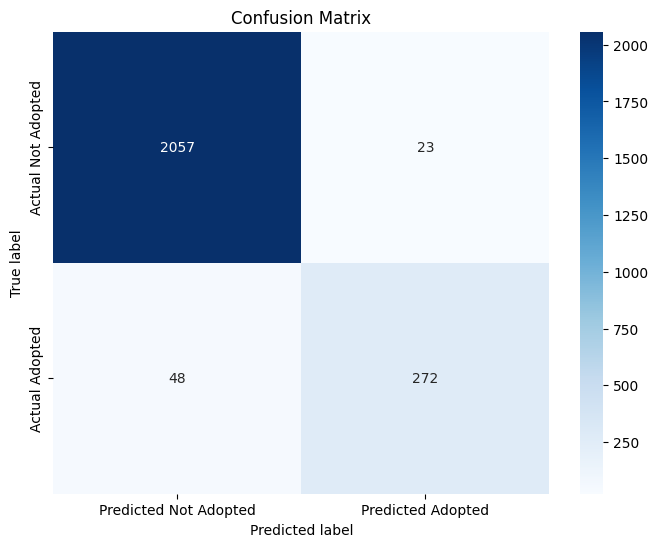

In [39]:
ac_logreg = accuracy_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg, average='weighted')
ll_logreg = log_loss(y_test, y_pred_logreg)
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
cr_logreg = classification_report(y_test, y_pred_logreg)

print('Gradient Boosting: Accuracy=%.3f' % (ac_logreg))
print('Gradient Boosting: f1-score=%.3f' % (f1_logreg))
print('Gradient Boosting: log-loss=%.3f' % (ll_logreg))
print(cr_logreg)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logreg, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted Not Adopted', 'Predicted Adopted'], yticklabels=['Actual Not Adopted', 'Actual Adopted'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

**After hyperparameter tuning, we can see that when predicting the test set, our logreg model indeed has a high accuracy 97% and decent f1-score 88% for adopted users.**

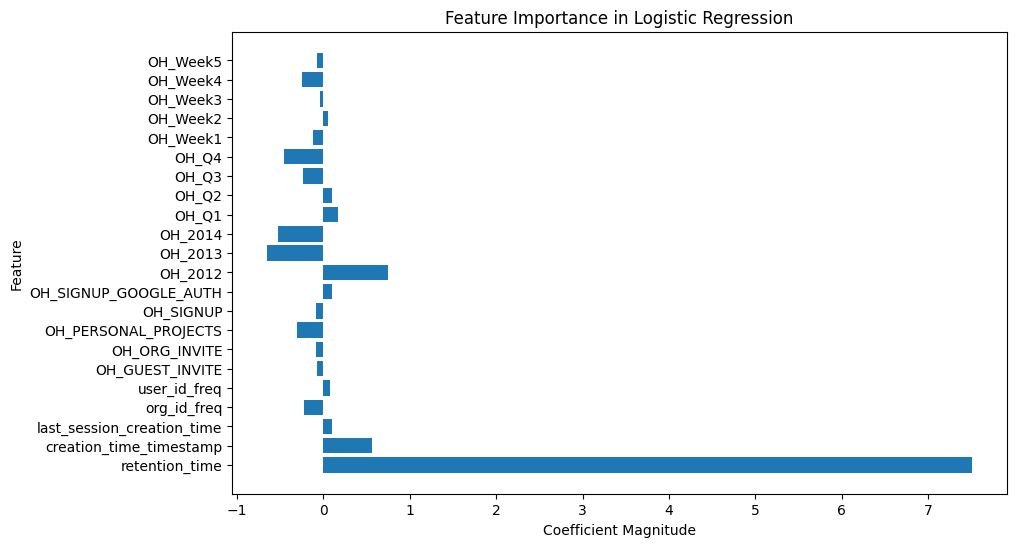

In [40]:
# Plot feature importances
coefficients = logreg.coef_[0]
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')
plt.show()

**After plotting the coefficient magnitudes to gain a perspective on which features have a strong relationship with the target variable, we found that retention_time, derived from the difference between creation_time_timestamp and last_session_creation_time, played an important role, suggesting that the longer users have been using the product, the greater the likelihood of their adoption. In order to improve Relax's future adoption rate, I will suggest the company collect more data and investigate which features of product they should enhance or introduce to retain existing users and attract new customers.**